# Time Series Forecasting using Facebook's Prophet

In [159]:
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [160]:
warnings.filterwarnings('ignore')
df = pd.read_csv('../input/AMS01-TVPP1-CloudCenter-Cluster.csv', index_col=[0], parse_dates=[0]) # We set the index column and know it has dates
df['date'] = 0
for i in range(len(df.timestamps)):
    df['date'][i] = datetime.datetime.fromtimestamp(df.timestamps[i]/1000.0).strftime('%Y-%m-%d')
    
df = df.drop(columns = ['timestamps'])
df['date']=pd.to_datetime(df['date'])
new_df = df.copy()
new_df.drop(columns = ['mem', 'disk'], inplace=True)
new_df.rename(columns = {'date':'ds', 'cpu':'y'}, inplace=True)
df.set_index('date',inplace=True)
df.head()

,mem,cpu,disk
date,,,
2019-09-30,54.881525,10080.829557,585.052852
2019-10-01,54.881756,10097.263431,585.843037
2019-10-02,54.882519,10047.982639,589.353789
2019-10-03,54.883016,10050.055318,593.655650
2019-10-04,54.885326,10120.385206,598.260093


In [161]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='cpu')

features_and_target = pd.concat([X, y], axis=1)
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,cpu
date,,,,,,,,,
2019-09-30,0,0,3,9,2019,273,30,40,10080.829557
2019-10-01,0,1,4,10,2019,274,1,40,10097.263431
2019-10-02,0,2,4,10,2019,275,2,40,10047.982639
2019-10-03,0,3,4,10,2019,276,3,40,10050.055318
2019-10-04,0,4,4,10,2019,277,4,40,10120.385206


## Plotting the Features to see trends

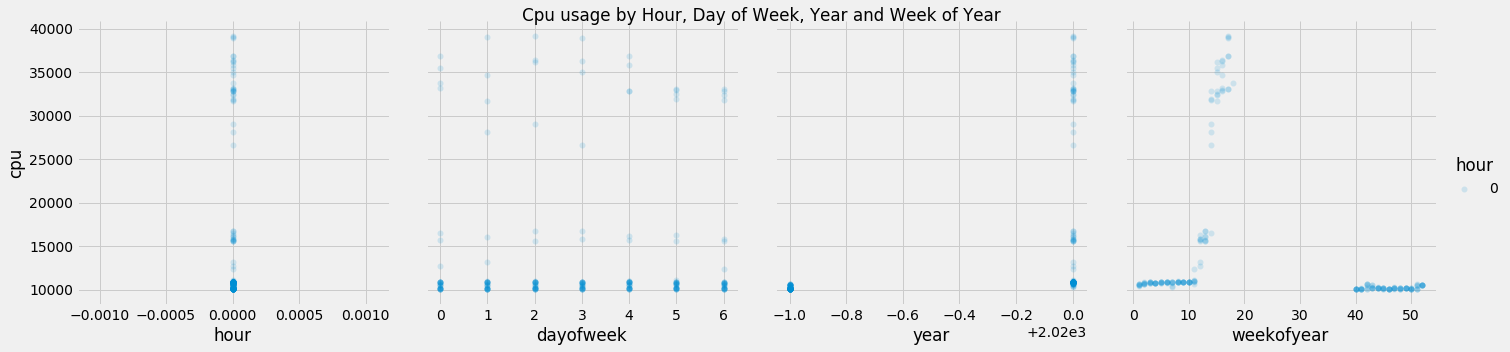

In [162]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='cpu',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Cpu usage by Hour, Day of Week, Year and Week of Year')
plt.show()

# Train/Test Split

In [163]:
def trainTestSplit(df,days = 153, trainSize = 0.8):
    training_data_length = int(days*trainSize)
    X_train = df[:training_data_length]
    X_test = df[training_data_length:days]
    return X_train, X_test

X_train, X_test = trainTestSplit(new_df)

def differencing(X_train, X_test):
    X_train['y'+'_first_difference'] = X_train['y'] - X_train['y'].shift(1)
    X_test['y'+'_first_difference'] = X_test['y'] - X_test['y'].shift(1)
    return X_train, X_test

X_train, X_test = differencing(X_train, X_test)

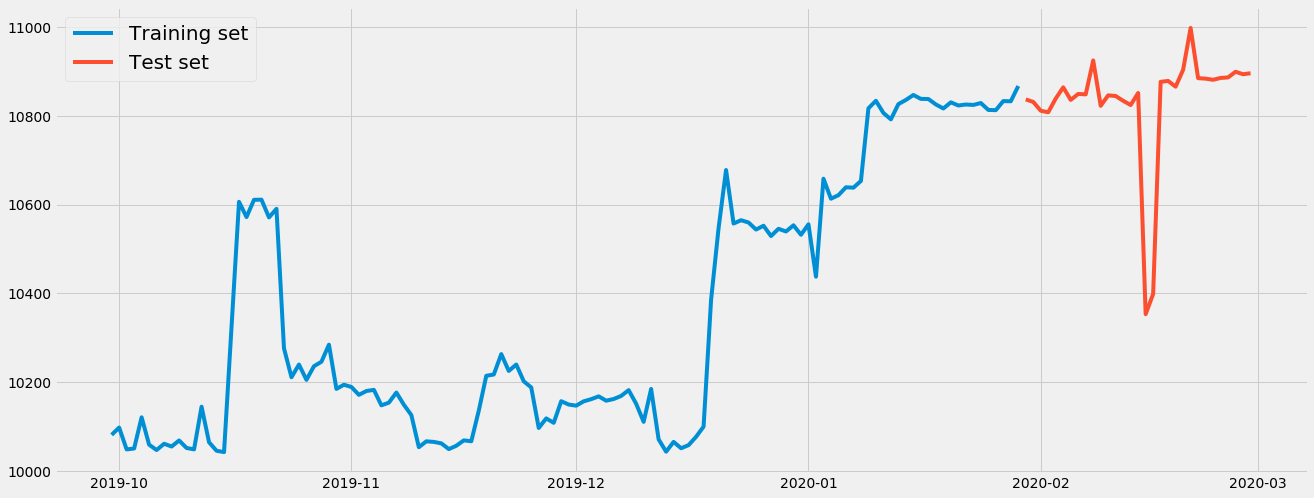

In [166]:
# Plot train and test so you can see where we have split
plt.figure(figsize = (20, 8))
plt.plot(X_train.ds, X_train.y, label = 'Training set')
plt.plot(X_test.ds, X_test.y, label = 'Test set')
plt.legend(fontsize=20)
plt.show()

# Simple Prophet Model

In [167]:
X_train.head()

,y,ds,y_first_difference
0,10080.829557,2019-09-30,NaN
1,10097.263431,2019-10-01,16.433874
2,10047.982639,2019-10-02,-49.280792
3,10050.055318,2019-10-03,2.072679
4,10120.385206,2019-10-04,70.329888


In [174]:
new_X_train = X_train.copy()
new_X_train.drop(columns = 'y', inplace = True)
new_X_train = new_X_train.rename(columns = {'y_first_difference':'y'})
new_X_train.head()

new_X_test = X_test.copy()
new_X_test.drop(columns = 'y', inplace = True)
new_X_test = new_X_test.rename(columns = {'y_first_difference':'y'})
new_X_test.head()

,ds,y
122,2020-01-30,NaN
123,2020-01-31,-5.672458
124,2020-02-01,-19.870616
125,2020-02-02,-3.441699
126,2020-02-03,30.961647


In [175]:
# Setup and train model and fit
model = Prophet(daily_seasonality=True)
model.fit(new_X_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [177]:
# Predict on training set with model
X_test_fcst = model.predict(new_X_test)
X_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-30,28.185413,-52.817730,117.519750,28.185413,28.185413,5.070602,5.070602,5.070602,-13.821048,-13.821048,-13.821048,18.891649,18.891649,18.891649,0.0,0.0,0.0,33.256015
1,2020-01-31,28.311061,-52.160974,119.650977,28.311056,28.311073,1.722274,1.722274,1.722274,-13.821048,-13.821048,-13.821048,15.543322,15.543322,15.543322,0.0,0.0,0.0,30.033336
2,2020-02-01,28.436710,-72.989576,107.679355,28.436683,28.436739,-14.767130,-14.767130,-14.767130,-13.821048,-13.821048,-13.821048,-0.946083,-0.946083,-0.946083,0.0,0.0,0.0,13.669579
3,2020-02-02,28.562358,-99.041331,72.079517,28.562310,28.562411,-36.192381,-36.192381,-36.192381,-13.821048,-13.821048,-13.821048,-22.371333,-22.371333,-22.371333,0.0,0.0,0.0,-7.630023
4,2020-02-03,28.688006,-81.704783,98.367297,28.687930,28.688090,-13.088272,-13.088272,-13.088272,-13.821048,-13.821048,-13.821048,0.732776,0.732776,0.732776,0.0,0.0,0.0,15.599734


# Compare Forecast to Actuals

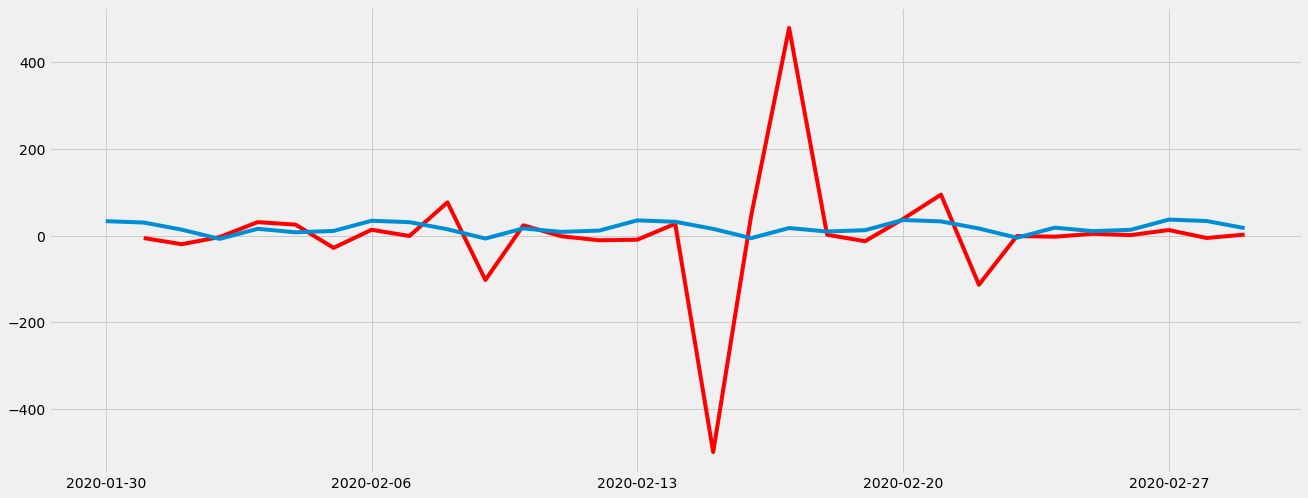

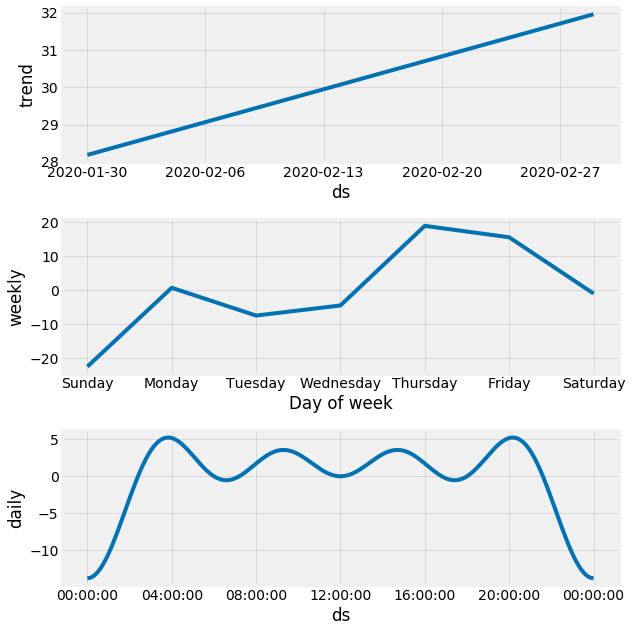

In [198]:
plt.figure(figsize=(20, 8))
plt.plot(new_X_test['ds'], new_X_test['y'], color='r')
plt.plot(new_X_test['ds'], X_test_fcst['yhat'])
plt.show()

# Plot the components of the model
fig = model.plot_components(X_test_fcst)

In [196]:
print(mean_squared_error(y_true=new_X_test['y'].dropna(), y_pred=X_test_fcst['yhat'][1:]))
print(mean_absolute_error(y_true=new_X_test['y'].dropna(),y_pred=X_test_fcst['yhat'][1:]))

17503.29734677224
60.58878114473505


# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

In [200]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=X_train.index.min(),
                              end=X_train.index.max())
test_holidays = cal.holidays(start=X_test.index.min(),
                             end=X_test.index.max())

In [201]:
X_train['is_holiday'] = X_train.ds.isin([d.date() for d in cal.holidays()])
holiday_df = X_train.loc[X_train['is_holiday']]
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['is_holiday'], axis=1)
holiday_df

,y,ds,y_first_difference,holiday
14,10044.954627,2019-10-14,-19.109260,USFederalHoliday
42,10066.219228,2019-11-11,13.247251,USFederalHoliday
59,10107.948608,2019-11-28,-9.949741,USFederalHoliday
86,10543.590281,2019-12-25,-15.922438,USFederalHoliday
93,10555.405372,2020-01-01,23.560449,USFederalHoliday
112,10830.374112,2020-01-20,13.846798,USFederalHoliday


In [202]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])
holiday_df

,y,ds,y_first_difference,holiday
14,10044.954627,2019-10-14,-19.109260,USFederalHoliday
42,10066.219228,2019-11-11,13.247251,USFederalHoliday
59,10107.948608,2019-11-28,-9.949741,USFederalHoliday
86,10543.590281,2019-12-25,-15.922438,USFederalHoliday
93,10555.405372,2020-01-01,23.560449,USFederalHoliday
112,10830.374112,2020-01-20,13.846798,USFederalHoliday


In [203]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df, daily_seasonality=True)
model_with_holidays.fit(new_X_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## Predict With Holidays

In [206]:
# Predict on training set with model
X_test_fcst_with_hols = model_with_holidays.predict(df=new_X_test)

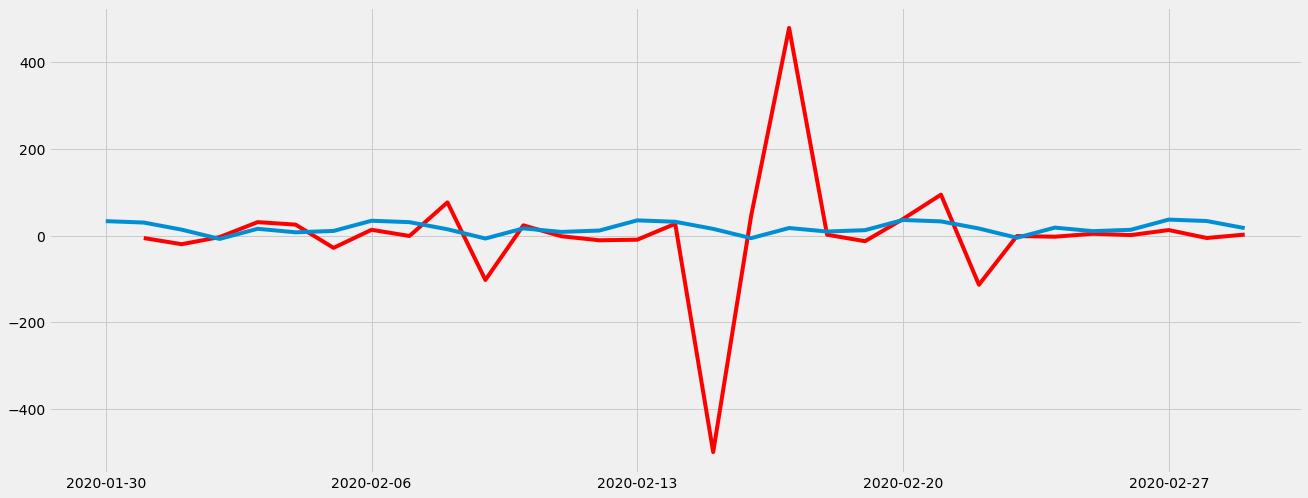

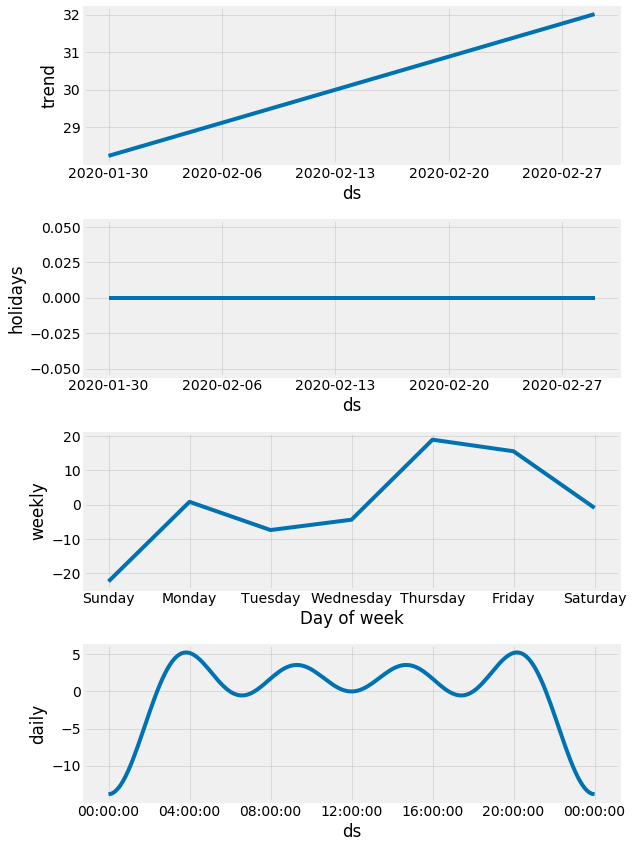

In [207]:
# Plot the forecast with the actuals
plt.figure(figsize=(20, 8))
plt.plot(new_X_test['ds'], new_X_test['y'], color='r')
plt.plot(new_X_test['ds'], X_test_fcst_with_hols['yhat'])
plt.show()

fig2 = model_with_holidays.plot_components(X_test_fcst_with_hols)

# Error Metrics with Holidays Added


In [209]:
print(mean_squared_error(y_true=new_X_test['y'].dropna(),y_pred=X_test_fcst_with_hols['yhat'][1:]))
print(mean_absolute_error(y_true=new_X_test['y'].dropna(),y_pred=X_test_fcst_with_hols['yhat'][1:]))

17501.000259394663
60.59334425886633
